In [1]:
# 要求版本>1.0.0
import cvxpy
cvxpy.__version__

'1.0.3'

# 组合优化

### 组合分配矢量

在这个例子中，我们展示了如何使用`CVXPY`进行投资组合优化。我们从基本定义开始。在投资组合优化中，我们有一定数额的资金投资于任何$n$个不同的资产。我们选择资金的比例($w_i$)投资于每个资产$i$，$i=1,\ldots,n$。

我们称$w\in {\bf R}^n$为**组合分配矢量**。当然，限制条件${\mathbf 1}^T w =1$。分配$w_i<0$意味着资产$i$为**空头头寸**，或者说当前借入股票卖出，随后买入归还。$w \geq 0$意味着**多头**组合。数量$$ \|w \|_1 = {\mathbf 1}^T w_+ + {\mathbf 1}^T w_- $$即常说的**杠杆**。

### 资产收益率

我们只对持有一个周期的投资进行建模。初始价格是$p_i > 0$，一个周期结束时价格为$p_i^+ >0$。资产收益率(小数)为$r_i = (p_i^+-p_i)/p_i$。组合收益率(小数)为$R = r^Tw$。

一个常见的模型，$r$是一个随机变量，其平均值为${\bf E}r = \mu$，协方差为${\bf E{(r-\mu)(r-\mu)^T}} = \Sigma$。
$R$是一个随机变量，${\bf E}R = \mu^T w$，${\bf var}(R) = w^T\Sigma w$。${\bf E}R$是组合平均**收益率**。${\bf var}(R)$为组合**风险**(风险有时也表达为${\bf std}(R) = \sqrt{{\bf var}(R)}$)

投资组合优化有两个相互矛盾的目标：高回报和低风险。

### 经典马柯维茨组合优化

经典马柯维茨组合优化求解优化问题

\begin{array}{ll} \mbox{maximize} & \mu^T w - \gamma w^T\Sigma w\\
\mbox{subject to} & {\bf 1}^T w = 1, \quad w \in {\cal W},
\end{array}

这里$w \in {\bf R}^n$为优化变量，$\cal W$为允许的组合集合(即，${\cal W} = {\bf R}_+^n$为仅多头组合), 而$\gamma >0$为*风险规避参数*.

目标$\mu^Tw - \gamma w^T\Sigma w$为*风险调整收益率*. 不同的$\gamma$给出最优*风险收益权衡*. 

我们可以通过固定收益和最小化风险来获得相同的风险收益权衡。

### 示例

在下面的代码中，我们计算并绘制了10种资产的最优风险-回报权衡，限制为仅多头投资组合。

In [2]:
# 生成数据用于限定多头投资组合优化
import numpy as np
np.random.seed(1)
n = 10
mu = np.abs(np.random.randn(n, 1))
Sigma = np.random.randn(n, n)
Sigma = Sigma.T.dot(Sigma)

In [3]:
mu

array([[1.62434536],
       [0.61175641],
       [0.52817175],
       [1.07296862],
       [0.86540763],
       [2.3015387 ],
       [1.74481176],
       [0.7612069 ],
       [0.3190391 ],
       [0.24937038]])

In [4]:
# Long only portfolio optimization.
from cvxpy import *
# 投资比例
w = Variable(shape=(n, 1))
# 
gamma = Parameter(nonneg=True)
# 投资组合收益率
ret = mu.T * w
risk = quad_form(w, Sigma)
# 杠杆为1，且不得有空头头寸
constraints = [sum(w) == 1, w >= 0]
prob = Problem(Maximize(ret - gamma * risk), constraints)

In [5]:
# Compute trade-off curve.
SAMPLES = 100
risk_data = np.zeros(SAMPLES)
ret_data = np.zeros(SAMPLES)
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
for i in range(SAMPLES):
    gamma.value = gamma_vals[i]
    prob.solve()
    risk_data[i] = sqrt(risk).value
    ret_data[i] = ret.value

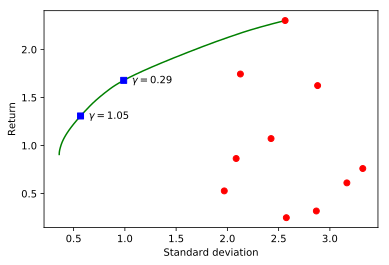

In [6]:
# Plot long only trade-off curve.
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

markers_on = [29, 40]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(risk_data, ret_data, 'g-')
for marker in markers_on:
    plt.plot(risk_data[marker], ret_data[marker], 'bs')
    ax.annotate(r"$\gamma = %.2f$" % gamma_vals[marker], xy=(risk_data[marker]+.08, ret_data[marker]-.03))
for i in range(n):
    plt.plot(sqrt(Sigma[i,i]).value, mu[i], 'ro')
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.show()

We plot below the return distributions for the two risk aversion values marked on the trade-off curve.
Notice that the probability of a loss is near 0 for the low risk value and far above 0 for the high risk value.

/home/ldf/anaconda3/envs/zipline/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


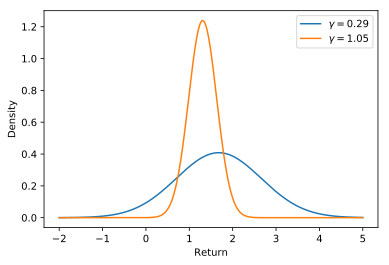

In [7]:
# Plot return distributions for two points on the trade-off curve.
import matplotlib.mlab as mlab
plt.figure()
for midx, idx in enumerate(markers_on):
    gamma.value = gamma_vals[idx]
    prob.solve()
    x = np.linspace(-2, 5, 1000)
    plt.plot(x, mlab.normpdf(x, ret.value, risk.value), label=r"$\gamma = %.2f$" % gamma.value)

plt.xlabel('Return')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.show()

### Portfolio constraints

There are many other possible portfolio constraints besides the long only constraint. With no constraint (${\cal W} = {\bf R}^n$), the optimization problem has a simple analytical solution. We will look in detail at a *leverage limit*, or the constraint that $\|w \|_1 \leq L^\mathrm{max}$.


Another interesting constraint is the *market neutral* constraint $m^T \Sigma w =0$, where $m_i$ is the capitalization of asset $i$.
$M = m^Tr$ is the *market return*, and $m^T \Sigma w = {\bf cov}(M,R)$.
The market neutral constraint ensures that the portfolio return is uncorrelated with the market return.

### Example

In the following code we compute and plot optimal risk-return trade-off curves for leverage limits of 1, 2, and 4.
Notice that more leverage increases returns and allows greater risk.

In [8]:
# Portfolio optimization with leverage limit.
Lmax = Parameter()
prob = Problem(Maximize(ret - gamma*risk), 
               [sum(w) == 1, 
                norm(w, 1) <= Lmax])

In [9]:
# Compute trade-off curve for each leverage limit.
L_vals = [1, 2, 4]
SAMPLES = 100
risk_data = np.zeros((len(L_vals), SAMPLES))
ret_data = np.zeros((len(L_vals), SAMPLES))
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
w_vals = []
for k, L_val in enumerate(L_vals):
    for i in range(SAMPLES):
        Lmax.value = L_val
        gamma.value = gamma_vals[i]
        prob.solve()
        risk_data[k, i] = sqrt(risk).value
        ret_data[k, i] = ret.value

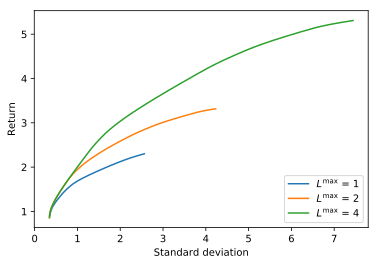

In [10]:
# Plot trade-off curves for each leverage limit.
for idx, L_val in enumerate(L_vals):
    plt.plot(risk_data[idx,:], ret_data[idx,:], label=r"$L^{\max}$ = %d" % L_val)
for w_val in w_vals:
    w.value = w_val
    plt.plot(sqrt(risk).value, ret.value, 'bs')
plt.xlabel('Standard deviation')
plt.ylabel('Return')
plt.legend(loc='lower right')
plt.show()

We next examine the points on each trade-off curve where $w^T\Sigma w = 2$.
We plot the amount of each asset held in each portfolio as bar graphs. (Negative holdings indicate a short position.)
Notice that some assets are held in a long position for the low leverage portfolio but in a short position in the higher leverage portfolios. 

In [11]:
# Portfolio optimization with a leverage limit and a bound on risk.
prob = Problem(Maximize(ret), 
              [sum(w) == 1, 
               norm(w, 1) <= Lmax,
               risk <= 2])

In [12]:
# Compute solution for different leverage limits.
for k, L_val in enumerate(L_vals):
    Lmax.value = L_val
    prob.solve()
    w_vals.append( w.value )

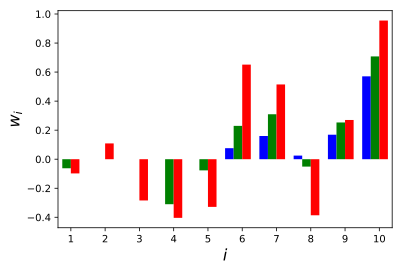

In [13]:
# Plot bar graph of holdings for different leverage limits.
colors = ['b', 'g', 'r']
indices = np.argsort(mu.flatten())
for idx, L_val in enumerate(L_vals):
     plt.bar(np.arange(1,n+1) + 0.25*idx - 0.375, 
             w_vals[idx][indices].flatten(), color=colors[idx], 
             label=r"$L^{\max}$ = %d" % L_val, width = 0.25)
plt.ylabel(r"$w_i$", fontsize=16)
plt.xlabel(r"$i$", fontsize=16)
plt.xlim([1-0.375, 10+.375])
plt.xticks(np.arange(1,n+1))
plt.show()

### Variations

There are many more variations of classical portfolio optimization. We might require that $\mu^T w \geq R^\mathrm{min}$ and minimize $w^T \Sigma w$ or $\|\Sigma ^{1/2} w\|_2$.
We could include the (broker) cost of short positions as the penalty $s^T (w)_-$ for some $s \geq 0$.
We could include transaction costs (from a previous portfolio $w^\mathrm{prev}$) as the penalty

$$
\kappa ^T |w-w^\mathrm{prev}|^\eta, \quad
\kappa \geq 0.
$$


Common values of $\eta$ are $\eta =1, ~ 3/2, ~2$.


### Factor covariance model

A particularly common and useful variation is to model the covariance matrix $\Sigma$ as a factor model

$$
\Sigma  =  F \tilde \Sigma F^T + D,
$$

where  $F \in {\bf R}^{n \times k}$, $k \ll n$ is the *factor loading matrix*. $k$ is the number of factors (or sectors) (typically 10s). $F_{ij}$ is the loading of asset $i$ to factor $j$.
$D$ is a diagonal matrix; $D_{ii}>0$ is the *idiosyncratic risk*. $\tilde \Sigma > 0$ is the *factor covariance matrix*.

$F^Tw \in {\bf R}^k$ gives the portfolio *factor exposures*. A portfolio is *factor $j$ neutral* if $(F^Tw)_j=0$.


### Portfolio optimization with factor covariance model

Using the factor covariance model, we frame the portfolio optimization problem as 

\begin{array}{ll} \mbox{maximize} & \mu^T w - \gamma \left(f^T \tilde \Sigma f  + w^TDw \right) \\
\mbox{subject to} & {\bf 1}^T w = 1, \quad f=F^Tw\\
& w \in {\cal W}, \quad f \in {\cal F},
\end{array}

where the variables are the allocations $w \in {\bf R}^n$ and factor exposures $f\in {\bf R}^k$ and $\cal F$ gives the factor exposure constraints.

Using the factor covariance model in the optimization problem has a computational advantage. The solve time is $O(nk^2)$ versus $O(n^3)$ for the standard problem.

### Example

In the following code we generate and solve a portfolio optimization problem with 50 factors and 3000 assets.
We set the leverage limit $=2$ and $\gamma=0.1$.

We solve the problem both with the covariance given as a single matrix and as a factor model.
Using CVXPY with the ECOS solver running in a single thread, the solve time was 687.26 seconds for the single matrix formulation and 0.58 seconds for the factor model formulation.
We collected the timings on a MacBook Pro with an Intel Core i7 processor.

In [14]:
# Generate data for factor model.
n = 3000
m = 50
np.random.seed(1)
mu = np.abs(np.random.randn(n, 1))
Sigma_tilde = np.random.randn(m, m)
Sigma_tilde = Sigma_tilde.T.dot(Sigma_tilde)
D = np.diag(np.random.uniform(0, 0.9, size=n))
F = np.random.randn(n, m)

In [15]:
# Factor model portfolio optimization.
w = Variable(shape=(n,1))
f = F.T*w
gamma = Parameter(nonneg=True)
Lmax = Parameter()
ret = mu.T*w 
risk = quad_form(f, Sigma_tilde) + quad_form(w, D)
prob_factor = Problem(Maximize(ret - gamma*risk), 
                     [sum(w) == 1, 
                      norm(w, 1) <= Lmax])

# Solve the factor model problem.
Lmax.value = 2
gamma.value = 0.1
prob_factor.solve(verbose=True)


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -7.950e-01  -1.112e+01  +2e+04  9e-01  1e-01  1e+00  3e+00    ---    ---    1  1  - |  -  - 
 1  -1.203e+01  -1.321e+01  +2e+03  8e-01  2e-02  5e-01  4e-01  0.9890  1e-01   1  1  1 |  0  0
 2  -1.017e+01  -1.030e+01  +2e+02  1e-01  2e-03  5e-03  3e-02  0.9049  8e-04   1  1  1 |  0  0
 3  -6.657e+00  -6.724e+00  +2e+02  6e-02  6e-04  7e-03  3e-02  0.2605  4e-01   1  2  2 |  0  0
 4  -6.355e+00  -6.401e+00  +1e+02  4e-02  4e-04  1e-02  2e-02  0.6410  7e-01   2  2  2 |  0  0
 5  -5.939e+00  -5.971e+00  +1e+02  3e-02  3e-04  8e-03  2e-02  0.3434  4e-01   2  2  2 |  0  0
 6  -6.381e+00  -6.414e+00  +1e+02  3e-02  3e-04  1e-02  2e-02  0.2204  9e-01   2  2  2 |  0  0
 7  -5.583e+00  -5.601e+00  +7e+01  2e-02  2e-04  7e-03  1e-02  0.7038  5e-01   2  2  2 |  0  0
 8  -5.647e+00  -5.664e+00  +7e+01  2e-02  2e-

4.6014667426339155

In [16]:
# Standard portfolio optimization with data from factor model.
risk = quad_form(w, F.dot(Sigma_tilde).dot(F.T) + D)
prob = Problem(Maximize(ret - gamma*risk), 
               [sum(w) == 1, 
                norm(w, 1) <= Lmax])

# Uncomment to solve the problem.
# WARNING: this will take many minutes to run.
# prob.solve(verbose=True)